In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
import matplotlib.tri
import okada_wrapper
import tectosaur as tct

In [100]:
TCTN = 40
CURVE = 1.0

corners = [[-1, 0, -1], [1, 0, -1], [1, 0, 1], [-1, 0, 1]]
src_mesh = tct.make_rect(TCTN, TCTN, corners)
src_mesh[0][:,1] = CURVE * np.abs(src_mesh[0][:,0])
#src_mesh[0][:,1] = CURVE * src_mesh[0][:,0] ** 2 + src_mesh[0][:,2]
def gauss_slip_fnc(x, z):
    r2 = x ** 2 + z ** 2
    R = 1.0
    out = (np.cos(np.sqrt(r2) * np.pi / R) + 1) / 2.0
    out[np.sqrt(r2) > R] = 0.0
    return out
dof_pts = src_mesh[0][src_mesh[1]]
x = dof_pts[:,:,0]
z = dof_pts[:,:,2]
slip = np.zeros((src_mesh[1].shape[0], 3, 3)).astype(np.float32)
slip[:,:,0] = gauss_slip_fnc(x, z)

In [101]:
H = tct.RegularizedSparseIntegralOp(
    6, 6, 6, 2, 5, 2.5,
    'elasticRH3', 'elasticRH3', [1.0, 0.25], src_mesh[0], src_mesh[1], np.float32,
    farfield_op_type = tct.TriToTriDirectFarfieldOp
)

[1165110:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[1165118:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[1165122:DEBUG:tectosaur.nearfield.nearfield_op]
         setup pairs integrator took 0.011703979223966599
[1165225:DEBUG:tectosaur.nearfield.nearfield_op]
         Coincident took 0.10168132930994034
[1165228:DEBUG:tectosaur.nearfield.nearfield_op]
         Coincident correction took 0.002257421612739563
[1165302:DEBUG:tectosaur.nearfield.nearfield_op]
         Find nearfield/adjacency took 0.07330239564180374
[1165357:DEBUG:tectosaur.nearfield.nearfield_op]
         Edge adjacent took 0.05439918115735054
[1165362:DEBUG:tectosaur.nearfield.nearfield_op]
         Edge adjacent correction took 0.004698384553194046
[1165457:DEBUG:tectosaur.nearfield.nearfield_op]
         Vert adjacent took 0.0934421494603157
[1165466:DEBUG:tectosaur.nearfield.nearfield_op]
         Vert adjacent correction took 0.008617687970399857
[1165609:DEBUG:t

In [102]:
traction_mass_op = tct.MassOp(4, src_mesh[0], src_mesh[1])

In [103]:
dof_pts = src_mesh[0][src_mesh[1]]
from tectosaur.util.geometry import unscaled_normals
ns = unscaled_normals(dof_pts)
ns /= np.linalg.norm(ns, axis = 1)[:, np.newaxis]
ns = np.repeat(ns, 3, axis = 0)

In [104]:
edge_dofs = tct.free_edge_dofs(src_mesh[1], tct.find_free_edges(src_mesh[1]))

In [105]:
obs_pts = dof_pts.reshape((-1,3))[edge_dofs]
obs_ns = ns[edge_dofs]
interior_op = tct.InteriorOp(obs_pts.copy(), obs_ns.copy(), src_mesh, 'elasticH3', 10, 6, 6, [1.0, 0.25], np.float32)

[1167448:DEBUG:tectosaur.util.gpu]
    returning cached gpu module matrix_free.cl
[1167453:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[1167457:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[1167494:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[1167495:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl


In [106]:
trac_edges = -interior_op.dot(slip.flatten())

In [134]:
vec_edge_dofs = np.tile(3 * np.array(edge_dofs)[:,np.newaxis], (1,3))
vec_edge_dofs[:,1] += 1
vec_edge_dofs[:,2] += 2
vec_edge_dofs = vec_edge_dofs.flatten()

In [ ]:
cs1 = tct.continuity_constraints(src_mesh[0], src_mesh[1], src_mesh[1].shape[0])
cs12 = cs1
cs1 = tct.traction_admissibility_constraints(src_mesh[0], src_mesh[1])
cs = cs1 + tct.simple_constraints(vec_edge_dofs, trac_edges)
cm, c_rhs, c_rhs_mat = tct.build_constraint_matrix(cs, src_mesh[1].shape[0] * 9)

> /home/tthompson/Dropbox/projects/tectosaur/tectosaur/tectosaur/continuity.py(188)traction_admissibility_constraints()
    186                     Tracer()()
    187 
--> 188                 def get_dof(row):
    189                     if row <= 2:
    190                         return (independent_tri_idx * 3 + independent_corner_idx) * 3 + row



ipdb>  t2t


array([[ 1.00000000e+00,  3.88578059e-16,  0.00000000e+00,
         5.55111512e-16, -3.05311332e-16,  0.00000000e+00],
       [ 4.03095505e-16,  5.00000000e-01,  0.00000000e+00,
        -3.53553391e-01,  3.53553391e-01,  0.00000000e+00],
       [ 1.27886331e-31, -1.18143350e-16,  1.00000000e+00,
        -8.35399640e-17,  1.52718784e-16, -2.22044605e-16],
       [ 5.93581318e-16, -3.53553391e-01,  0.00000000e+00,
         7.50000000e-01,  2.50000000e-01,  0.00000000e+00],
       [-3.67195699e-16,  3.53553391e-01,  0.00000000e+00,
         2.50000000e-01,  7.50000000e-01,  0.00000000e+00],
       [-3.46924086e-32,  3.20493781e-17, -2.00272710e-16,
         2.26623326e-17, -1.41658845e-32,  1.00000000e+00]])


ipdb>  independent_n


array([-0.70710678,  0.70710678,  0.        ])


ipdb>  dependent_n


array([-1.08246745e-15,  1.00000000e+00,  0.00000000e+00])


In [127]:
for i in range(10):
    C1 = cs12[i]
    C2 = cs1[i]
    print((C1.terms[0].dof, C1.terms[0].val), (C1.terms[1].dof, C1n.terms[1].val))
    print((C2.terms[0].dof, C2.terms[0].val), (C2.terms[1].dof, C2.terms[1].val))

(15, 1.0) (6, -1.0)
(15, 1.0) (6, -1.0)
(16, 1.0) (7, -1.0)
(16, 1.0) (7, -1.0)
(17, 1.0) (8, -1.0)
(17, 1.0) (8, -1.0)
(702, 1.0) (6, -1.0)
(702, 1.0) (6, -1.0)
(703, 1.0) (7, -1.0)
(703, 1.0) (7, -1.0)
(704, 1.0) (8, -1.0)
(704, 1.0) (8, -1.0)
(702, 1.0) (15, -1.0)
(702, 1.0) (15, -1.0)
(703, 1.0) (16, -1.0)
(703, 1.0) (16, -1.0)
(704, 1.0) (17, -1.0)
(704, 1.0) (17, -1.0)
(717, 1.0) (708, -1.0)
(717, 1.0) (708, -1.0)


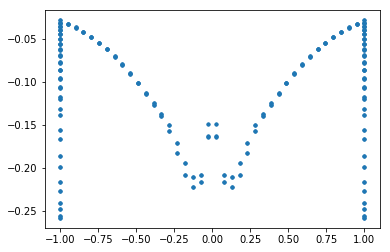

In [128]:
plt.plot(obs_pts[:,0], trac_edges.reshape((-1,3))[:,0], '.')
plt.show()

In [129]:
constrained_traction_mass_op = cm.T.dot(traction_mass_op.mat.dot(cm))

In [130]:
rhs = -cm.T.dot(H.dot(slip.flatten())) - cm.T.dot(traction_mass_op.mat.dot(c_rhs))
#rhs = -cm.T.dot(traction_mass_op.mat.dot(c_rhs2))
soln = cg(constrained_traction_mass_op, rhs)
out = cm.dot(soln[0]) + c_rhs

[1228825:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[1228840:DEBUG:tectosaur.ops.sparse_integral_op]
     farfield_dot took 0.015006240457296371
[1228841:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[1228895:DEBUG:tectosaur.ops.sparse_integral_op]
     nearfield_dot took 0.053365081548690796


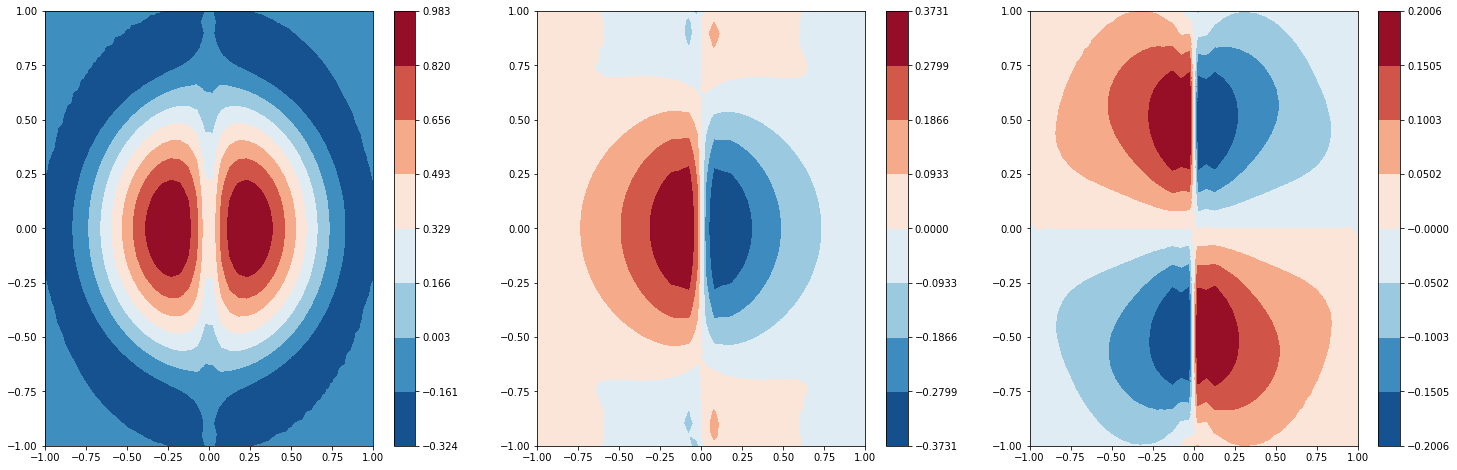

In [131]:
def plot_fnc(triang, f):
    levels = np.linspace(np.min(f) - 1e-12, np.max(f) + 1e-12, 9)
    #levels = np.linspace(-0.2, 0.2, 31)
    cntf = plt.tricontourf(triang, f, levels = levels, cmap = 'RdBu_r')
    #plt.tricontour(triang, f, levels = levels, linestyles = 'solid', colors = 'k', linewidths = 0.5)
    plt.colorbar(cntf)

triang = matplotlib.tri.Triangulation(src_mesh[0][:,0], src_mesh[0][:,2], src_mesh[1])
plt.figure(figsize = (25,8))
for d in range(3):
    f = out.reshape((-1,3,3))[:,:,d]
    f_pts = np.zeros(src_mesh[0].shape[0])
    f_pts[src_mesh[1]] = f
    plt.subplot(1, 3, d + 1)
    plot_fnc(triang, f_pts)
plt.show()